# Thermo-desorption spectrum

This validation case is a thermo-desorption spectrum measurement perfomed by Ogorodnikova et al. {cite}`ogorodnikova_deuterium_2003`.

Deuterium ions at 200 eV were implanted in a 0.5 mm thick sample of high purity tungsten foil (PCW).

The ion beam was turned on for 400 s which corresponds to a fluence of $1.0 \times 10^{22} \ \mathrm{D \ m^{-2}}$

The diffusivity of tungsten is as measured by Frauenfelder {cite}`frauenfelder_permeation_1968`.

## FESTIM code

In [1]:
import festim as F
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

model = F.Simulation()

vertices = np.concatenate(
    [
        np.linspace(0, 30e-9, num=200),
        np.linspace(30e-9, 3e-6, num=300),
        np.linspace(3e-6, 20e-6, num=200),
    ]
)

model.mesh = F.MeshFromVertices(vertices)
# Material Setup, only W
tungsten = F.Material(
    id=1,
    D_0=4.1e-07,  # m2/s
    E_D=0.39,  # eV
)

model.materials = tungsten
import sympy as sp

imp_fluence = 1e22
incident_flux = 2.5e19  # beam strength from paper

imp_time = imp_fluence / incident_flux  # s

ion_flux = sp.Piecewise((incident_flux, F.t <= imp_time), (0, True))

source_term = F.ImplantationFlux(
    flux=ion_flux, imp_depth=4.5e-9, width=2.5e-9, volume=1  # H/m2/s  # m  # m
)

model.sources = [source_term]
# trap settings
w_atom_density = 6.3e28  # atom/m3

trap_1 = F.Trap(
    k_0=4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
    E_k=0.39,
    p_0=1e13,
    E_p=0.87,
    density=1.3e-3 * w_atom_density,
    materials=tungsten,
)

trap_2 = F.Trap(
    k_0=4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
    E_k=0.39,
    p_0=1e13,
    E_p=1.0,
    density=4e-4 * w_atom_density,
    materials=tungsten,
)

center = 4.5e-9
width = 2.5e-9
distribution = (
    1 / (width * (2 * sp.pi) ** 0.5) * sp.exp(-0.5 * ((F.x - center) / width) ** 2)
)

trap_3 = F.ExtrinsicTrap(
    k_0=4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
    E_k=0.39,
    p_0=1e13,
    E_p=1.5,
    phi_0=ion_flux,
    n_amax=1e-01 * w_atom_density,
    f_a=distribution,
    eta_a=6e-4,
    n_bmax=1e-02 * w_atom_density,
    f_b=sp.Piecewise((1e6, F.x < 1e-6), (0, True)),
    eta_b=2e-4,
    materials=tungsten,
)

model.traps = [trap_1, trap_2, trap_3]
# boundary conditions
model.boundary_conditions = [F.DirichletBC(surfaces=[1, 2], value=0, field=0)]
implantation_temp = 293  # K
temperature_ramp = 8  # K/s

start_tds = imp_time + 50  # s

model.T = F.Temperature(
    value=sp.Piecewise(
        (implantation_temp, F.t < start_tds),
        (implantation_temp + temperature_ramp * (F.t - start_tds), True),
    )
)

min_temp, max_temp = implantation_temp, 700

model.dt = F.Stepsize(
    initial_value=0.5,
    stepsize_change_ratio=1.1,
    max_stepsize=lambda t: 0.5 if t > start_tds else None,
    dt_min=1e-05,
    milestones=[start_tds],
)

model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-09,
    final_time=start_tds
    + (max_temp - implantation_temp) / temperature_ramp,  # time to reach max temp
)

derived_quantities = F.DerivedQuantities(
    [
        F.TotalVolume("solute", volume=1),
        F.TotalVolume("retention", volume=1),
        F.TotalVolume("1", volume=1),
        F.TotalVolume("2", volume=1),
        F.TotalVolume("3", volume=1),
        F.HydrogenFlux(surface=1),
        F.HydrogenFlux(surface=2),
    ],
)

model.exports = [derived_quantities]

model.initialise()
model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/komodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        5.0e+02 s    Ellapsed time so far: 12.7 s


## Comparison with experimental data

The results produced by FESTIM are in good agreement with the experimental data.

/home/komodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/komodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/komodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


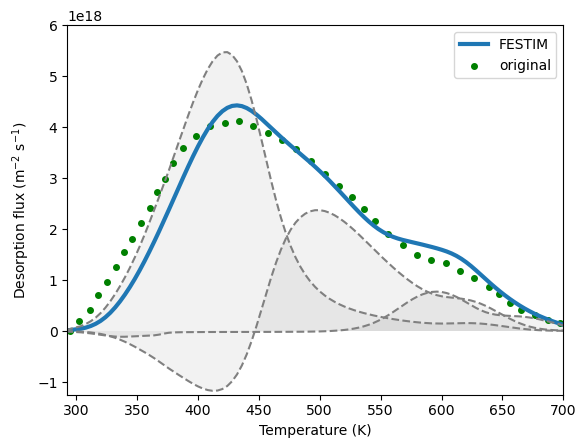

In [2]:
t = derived_quantities.t
flux_left = derived_quantities.filter(fields="solute", surfaces=1).data
flux_right = derived_quantities.filter(fields="solute", surfaces=2).data
flux_total = -np.array(flux_left) - np.array(flux_right)

trap_1 = derived_quantities.filter(fields="1").data
trap_2 = derived_quantities.filter(fields="2").data
trap_3 = derived_quantities.filter(fields="3").data

contribution_trap_1 = -np.diff(trap_1) / np.diff(t)
contribution_trap_2 = -np.diff(trap_2) / np.diff(t)
contribution_trap_3 = -np.diff(trap_3) / np.diff(t)

t = np.array(t)
temp = implantation_temp + 8 * (t - start_tds)

# plotting simulation data
plt.plot(temp, flux_total, linewidth=3, label="FESTIM")

# plotting trap contributions
plt.plot(temp[1:], contribution_trap_1, linestyle="--", color="grey")
plt.fill_between(temp[1:], 0, contribution_trap_1, facecolor="grey", alpha=0.1)
plt.plot(temp[1:], contribution_trap_2, linestyle="--", color="grey")
plt.fill_between(temp[1:], 0, contribution_trap_2, facecolor="grey", alpha=0.1)
plt.plot(temp[1:], contribution_trap_3, linestyle="--", color="grey")
plt.fill_between(temp[1:], 0, contribution_trap_3, facecolor="grey", alpha=0.1)


# plotting original data
experimental_tds = np.genfromtxt("ogorodnikova-original.csv", delimiter=",")
experimental_temp = experimental_tds[:, 0]
experimental_flux = experimental_tds[:, 1]
plt.scatter(experimental_temp, experimental_flux, color="green", label="original", s=16)

plt.legend()
plt.xlim(min_temp, max_temp)
plt.ylim(bottom=-1.25e18, top=0.6 * 1e19)
plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Temperature (K)")

plt.show()

```{note}
The experimental data was taken from Figure 5 of the original experiment paper {cite}`ogorodnikova_deuterium_2003` using [WebPlotDigitizer](https://automeris.io/)
```